In [1]:
import os
import sys

__dir__ = os.path.dirname(os.path.abspath("__file__"))
sys.path.append(__dir__)
sys.path.insert(0, os.path.abspath(os.path.join(__dir__, "../..")))

os.environ["FLAGS_allocator_strategy"] = "auto_growth"

In [10]:
import tools.infer.pytorchocr_utility as utility
import copy
from PIL import Image
import cv2
import numpy as np
import math
import time
import torch
from pytorchocr.base_ocr_v20 import BaseOCRV20
import tools.infer.pytorchocr_utility as utility
from pytorchocr.postprocess import build_post_process
from pytorchocr.utils.utility import get_image_file_list, check_and_read_gif

In [3]:
class TextRecognizer(BaseOCRV20):
    def __init__(self, args, **kwargs):
        self.rec_image_shape = [int(v) for v in args.rec_image_shape.split(",")]
        self.character_type = args.rec_char_type
        self.rec_batch_num = args.rec_batch_num
        self.rec_algorithm = args.rec_algorithm
        self.max_text_length = args.max_text_length
        postprocess_params = {
            'name': 'CTCLabelDecode',
            "character_type": args.rec_char_type,
            "character_dict_path": args.rec_char_dict_path,
            "use_space_char": args.use_space_char
        }
        if self.rec_algorithm == "SRN":
            postprocess_params = {
                'name': 'SRNLabelDecode',
                "character_type": args.rec_char_type,
                "character_dict_path": args.rec_char_dict_path,
                "use_space_char": args.use_space_char
            }
        elif self.rec_algorithm == "RARE":
            postprocess_params = {
                'name': 'AttnLabelDecode',
                "character_type": args.rec_char_type,
                "character_dict_path": args.rec_char_dict_path,
                "use_space_char": args.use_space_char
            }
        elif self.rec_algorithm == 'NRTR':
            postprocess_params = {
                'name': 'NRTRLabelDecode',
                "character_dict_path": args.rec_char_dict_path,
                "use_space_char": args.use_space_char
            }
        elif self.rec_algorithm == "SAR":
            postprocess_params = {
                'name': 'SARLabelDecode',
                "character_dict_path": args.rec_char_dict_path,
                "use_space_char": args.use_space_char
            }
        elif self.rec_algorithm == 'ViTSTR':
            postprocess_params = {
                'name': 'ViTSTRLabelDecode',
                "character_dict_path": args.rec_char_dict_path,
                "use_space_char": args.use_space_char
            }
        elif self.rec_algorithm == "CAN":
            self.inverse = args.rec_image_inverse
            postprocess_params = {
                'name': 'CANLabelDecode',
                "character_dict_path": args.rec_char_dict_path,
                "use_space_char": args.use_space_char
            }
        elif self.rec_algorithm == 'RFL':
            postprocess_params = {
                'name': 'RFLLabelDecode',
                "character_dict_path": None,
                "use_space_char": args.use_space_char
            }
        elif self.rec_algorithm == "CRNN":
            postprocess_params = {
                'name': 'CTCLabelDecode',
                "character_dict_path": args.rec_char_dict_path,
                "use_space_char": args.use_space_char
            }
        print(args.rec_char_dict_path)
        self.postprocess_op = build_post_process(postprocess_params)

        use_gpu = args.use_gpu
        self.use_gpu = torch.cuda.is_available() and use_gpu

        self.limited_max_width = args.limited_max_width
        self.limited_min_width = args.limited_min_width

        self.weights_path = args.rec_model_path
        self.yaml_path = args.rec_yaml_path

        char_num = len(getattr(self.postprocess_op, 'character'))
        network_config = utility.AnalysisConfig(self.weights_path, self.yaml_path, char_num)
        weights = self.read_pytorch_weights(self.weights_path)

        self.out_channels = self.get_out_channels(weights)
        if self.rec_algorithm == 'NRTR':
            self.out_channels = list(weights.values())[-1].numpy().shape[0]
        elif self.rec_algorithm == 'SAR':
            self.out_channels = list(weights.values())[-3].numpy().shape[0]

        kwargs['out_channels'] = self.out_channels
        super(TextRecognizer, self).__init__(network_config, **kwargs)

        self.load_state_dict(weights)
        self.net.eval()
        if self.use_gpu:
            self.net.cuda()

    def resize_norm_img(self, img, max_wh_ratio):
        imgC, imgH, imgW = self.rec_image_shape
        if self.rec_algorithm == 'NRTR' or self.rec_algorithm == 'ViTSTR':
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # return padding_im
            image_pil = Image.fromarray(np.uint8(img))
            if self.rec_algorithm == 'ViTSTR':
                img = image_pil.resize([imgW, imgH], Image.BICUBIC)
            else:
                img = image_pil.resize([imgW, imgH], Image.ANTIALIAS)
            img = np.array(img)
            norm_img = np.expand_dims(img, -1)
            norm_img = norm_img.transpose((2, 0, 1))
            if self.rec_algorithm == 'ViTSTR':
                norm_img = norm_img.astype(np.float32) / 255.
            else:
                norm_img = norm_img.astype(np.float32) / 128. - 1.
            return norm_img
        elif self.rec_algorithm == 'RFL':
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized_image = cv2.resize(
                img, (imgW, imgH), interpolation=cv2.INTER_CUBIC)
            resized_image = resized_image.astype('float32')
            resized_image = resized_image / 255
            resized_image = resized_image[np.newaxis, :]
            resized_image -= 0.5
            resized_image /= 0.5
            return resized_image

        assert imgC == img.shape[2]
        max_wh_ratio = max(max_wh_ratio, imgW / imgH)
        imgW = int((imgH * max_wh_ratio))
        imgW = max(min(imgW, self.limited_max_width), self.limited_min_width)
        h, w = img.shape[:2]
        ratio = w / float(h)
        ratio_imgH = math.ceil(imgH * ratio)
        ratio_imgH = max(ratio_imgH, self.limited_min_width)
        if ratio_imgH > imgW:
            resized_w = imgW
        else:
            resized_w = int(ratio_imgH)
        resized_image = cv2.resize(img, (resized_w, imgH))
        resized_image = resized_image.astype('float32')
        resized_image = resized_image.transpose((2, 0, 1)) / 255
        resized_image -= 0.5
        resized_image /= 0.5
        padding_im = np.zeros((imgC, imgH, imgW), dtype=np.float32)
        padding_im[:, :, 0:resized_w] = resized_image
        return padding_im

    def resize_norm_img_svtr(self, img, image_shape):

        imgC, imgH, imgW = image_shape
        resized_image = cv2.resize(
            img, (imgW, imgH), interpolation=cv2.INTER_LINEAR)
        resized_image = resized_image.astype('float32')
        resized_image = resized_image.transpose((2, 0, 1)) / 255
        resized_image -= 0.5
        resized_image /= 0.5
        return resized_image


    def resize_norm_img_srn(self, img, image_shape):
        imgC, imgH, imgW = image_shape

        img_black = np.zeros((imgH, imgW))
        im_hei = img.shape[0]
        im_wid = img.shape[1]

        if im_wid <= im_hei * 1:
            img_new = cv2.resize(img, (imgH * 1, imgH))
        elif im_wid <= im_hei * 2:
            img_new = cv2.resize(img, (imgH * 2, imgH))
        elif im_wid <= im_hei * 3:
            img_new = cv2.resize(img, (imgH * 3, imgH))
        else:
            img_new = cv2.resize(img, (imgW, imgH))

        img_np = np.asarray(img_new)
        img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2GRAY)
        img_black[:, 0:img_np.shape[1]] = img_np
        img_black = img_black[:, :, np.newaxis]

        row, col, c = img_black.shape
        c = 1

        return np.reshape(img_black, (c, row, col)).astype(np.float32)

    def srn_other_inputs(self, image_shape, num_heads, max_text_length):

        imgC, imgH, imgW = image_shape
        feature_dim = int((imgH / 8) * (imgW / 8))

        encoder_word_pos = np.array(range(0, feature_dim)).reshape(
            (feature_dim, 1)).astype('int64')
        gsrm_word_pos = np.array(range(0, max_text_length)).reshape(
            (max_text_length, 1)).astype('int64')

        gsrm_attn_bias_data = np.ones((1, max_text_length, max_text_length))
        gsrm_slf_attn_bias1 = np.triu(gsrm_attn_bias_data, 1).reshape(
            [-1, 1, max_text_length, max_text_length])
        gsrm_slf_attn_bias1 = np.tile(
            gsrm_slf_attn_bias1,
            [1, num_heads, 1, 1]).astype('float32') * [-1e9]

        gsrm_slf_attn_bias2 = np.tril(gsrm_attn_bias_data, -1).reshape(
            [-1, 1, max_text_length, max_text_length])
        gsrm_slf_attn_bias2 = np.tile(
            gsrm_slf_attn_bias2,
            [1, num_heads, 1, 1]).astype('float32') * [-1e9]

        encoder_word_pos = encoder_word_pos[np.newaxis, :]
        gsrm_word_pos = gsrm_word_pos[np.newaxis, :]

        return [
            encoder_word_pos, gsrm_word_pos, gsrm_slf_attn_bias1,
            gsrm_slf_attn_bias2
        ]

    def process_image_srn(self, img, image_shape, num_heads, max_text_length):
        norm_img = self.resize_norm_img_srn(img, image_shape)
        norm_img = norm_img[np.newaxis, :]

        [encoder_word_pos, gsrm_word_pos, gsrm_slf_attn_bias1, gsrm_slf_attn_bias2] = \
            self.srn_other_inputs(image_shape, num_heads, max_text_length)

        gsrm_slf_attn_bias1 = gsrm_slf_attn_bias1.astype(np.float32)
        gsrm_slf_attn_bias2 = gsrm_slf_attn_bias2.astype(np.float32)
        encoder_word_pos = encoder_word_pos.astype(np.int64)
        gsrm_word_pos = gsrm_word_pos.astype(np.int64)

        return (norm_img, encoder_word_pos, gsrm_word_pos, gsrm_slf_attn_bias1,
                gsrm_slf_attn_bias2)

    def resize_norm_img_sar(self, img, image_shape,
                            width_downsample_ratio=0.25):
        imgC, imgH, imgW_min, imgW_max = image_shape
        h = img.shape[0]
        w = img.shape[1]
        valid_ratio = 1.0
        # make sure new_width is an integral multiple of width_divisor.
        width_divisor = int(1 / width_downsample_ratio)
        # resize
        ratio = w / float(h)
        resize_w = math.ceil(imgH * ratio)
        if resize_w % width_divisor != 0:
            resize_w = round(resize_w / width_divisor) * width_divisor
        if imgW_min is not None:
            resize_w = max(imgW_min, resize_w)
        if imgW_max is not None:
            valid_ratio = min(1.0, 1.0 * resize_w / imgW_max)
            resize_w = min(imgW_max, resize_w)
        resized_image = cv2.resize(img, (resize_w, imgH))
        resized_image = resized_image.astype('float32')
        # norm
        if image_shape[0] == 1:
            resized_image = resized_image / 255
            resized_image = resized_image[np.newaxis, :]
        else:
            resized_image = resized_image.transpose((2, 0, 1)) / 255
        resized_image -= 0.5
        resized_image /= 0.5
        resize_shape = resized_image.shape
        padding_im = -1.0 * np.ones((imgC, imgH, imgW_max), dtype=np.float32)
        padding_im[:, :, 0:resize_w] = resized_image
        pad_shape = padding_im.shape

        return padding_im, resize_shape, pad_shape, valid_ratio


    def norm_img_can(self, img, image_shape):

        img = cv2.cvtColor(
            img, cv2.COLOR_BGR2GRAY)  # CAN only predict gray scale image

        if self.inverse:
            img = 255 - img

        if self.rec_image_shape[0] == 1:
            h, w = img.shape
            _, imgH, imgW = self.rec_image_shape
            if h < imgH or w < imgW:
                padding_h = max(imgH - h, 0)
                padding_w = max(imgW - w, 0)
                img_padded = np.pad(img, ((0, padding_h), (0, padding_w)),
                                    'constant',
                                    constant_values=(255))
                img = img_padded

        img = np.expand_dims(img, 0) / 255.0  # h,w,c -> c,h,w
        img = img.astype('float32')

        return img

    def __call__(self, img_list):
        img_num = len(img_list)
        # Calculate the aspect ratio of all text bars
        width_list = []
        for img in img_list:
            width_list.append(img.shape[1] / float(img.shape[0]))
        # Sorting can speed up the recognition process
        indices = np.argsort(np.array(width_list))

        # rec_res = []
        rec_res = [['', 0.0]] * img_num
        batch_num = self.rec_batch_num
        elapse = 0
        for beg_img_no in range(0, img_num, batch_num):
            end_img_no = min(img_num, beg_img_no + batch_num)
            norm_img_batch = []
            max_wh_ratio = 0
            for ino in range(beg_img_no, end_img_no):
                # h, w = img_list[ino].shape[0:2]
                h, w = img_list[indices[ino]].shape[0:2]
                wh_ratio = w * 1.0 / h
                max_wh_ratio = max(max_wh_ratio, wh_ratio)
            for ino in range(beg_img_no, end_img_no):
                if self.rec_algorithm == "SAR":
                    norm_img, _, _, valid_ratio = self.resize_norm_img_sar(
                        img_list[indices[ino]], self.rec_image_shape)
                    norm_img = norm_img[np.newaxis, :]
                    valid_ratio = np.expand_dims(valid_ratio, axis=0)
                    valid_ratios = []
                    valid_ratios.append(valid_ratio)
                    norm_img_batch.append(norm_img)

                elif self.rec_algorithm == "SVTR":
                    norm_img = self.resize_norm_img_svtr(img_list[indices[ino]],
                                                         self.rec_image_shape)
                    norm_img = norm_img[np.newaxis, :]
                    norm_img_batch.append(norm_img)
                elif self.rec_algorithm == "SRN":
                    norm_img = self.process_image_srn(img_list[indices[ino]],
                                                      self.rec_image_shape, 8,
                                                      self.max_text_length)
                    encoder_word_pos_list = []
                    gsrm_word_pos_list = []
                    gsrm_slf_attn_bias1_list = []
                    gsrm_slf_attn_bias2_list = []
                    encoder_word_pos_list.append(norm_img[1])
                    gsrm_word_pos_list.append(norm_img[2])
                    gsrm_slf_attn_bias1_list.append(norm_img[3])
                    gsrm_slf_attn_bias2_list.append(norm_img[4])
                    norm_img_batch.append(norm_img[0])
                elif self.rec_algorithm == "CAN":
                    norm_img = self.norm_img_can(img_list[indices[ino]],
                                                 max_wh_ratio)
                    norm_img = norm_img[np.newaxis, :]
                    norm_img_batch.append(norm_img)
                    norm_image_mask = np.ones(norm_img.shape, dtype='float32')
                    word_label = np.ones([1, 36], dtype='int64')
                    norm_img_mask_batch = []
                    word_label_list = []
                    norm_img_mask_batch.append(norm_image_mask)
                    word_label_list.append(word_label)
                else:
                    norm_img = self.resize_norm_img(img_list[indices[ino]],
                                                    max_wh_ratio)
                    norm_img = norm_img[np.newaxis, :]
                    norm_img_batch.append(norm_img)
            norm_img_batch = np.concatenate(norm_img_batch)
            norm_img_batch = norm_img_batch.copy()

            if self.rec_algorithm == "SRN":
                starttime = time.time()
                encoder_word_pos_list = np.concatenate(encoder_word_pos_list)
                gsrm_word_pos_list = np.concatenate(gsrm_word_pos_list)
                gsrm_slf_attn_bias1_list = np.concatenate(
                    gsrm_slf_attn_bias1_list)
                gsrm_slf_attn_bias2_list = np.concatenate(
                    gsrm_slf_attn_bias2_list)

                with torch.no_grad():
                    inp = torch.from_numpy(norm_img_batch)
                    encoder_word_pos_inp = torch.from_numpy(encoder_word_pos_list)
                    gsrm_word_pos_inp = torch.from_numpy(gsrm_word_pos_list)
                    gsrm_slf_attn_bias1_inp = torch.from_numpy(gsrm_slf_attn_bias1_list)
                    gsrm_slf_attn_bias2_inp = torch.from_numpy(gsrm_slf_attn_bias2_list)

                    if self.use_gpu:
                        inp = inp.cuda()
                        encoder_word_pos_inp = encoder_word_pos_inp.cuda()
                        gsrm_word_pos_inp = gsrm_word_pos_inp.cuda()
                        gsrm_slf_attn_bias1_inp = gsrm_slf_attn_bias1_inp.cuda()
                        gsrm_slf_attn_bias2_inp = gsrm_slf_attn_bias2_inp.cuda()

                    backbone_out = self.net.backbone(inp) # backbone_feat
                    prob_out = self.net.head(backbone_out, [encoder_word_pos_inp, gsrm_word_pos_inp, gsrm_slf_attn_bias1_inp, gsrm_slf_attn_bias2_inp])
                # preds = {"predict": prob_out[2]}
                preds = {"predict": prob_out["predict"]}

            elif self.rec_algorithm == "SAR":
                starttime = time.time()
                # valid_ratios = np.concatenate(valid_ratios)
                # inputs = [
                #     norm_img_batch,
                #     valid_ratios,
                # ]

                with torch.no_grad():
                    inp = torch.from_numpy(norm_img_batch)
                    if self.use_gpu:
                        inp = inp.cuda()
                    preds = self.net(inp)

            elif self.rec_algorithm == "CAN":
                starttime = time.time()
                norm_img_mask_batch = np.concatenate(norm_img_mask_batch)
                word_label_list = np.concatenate(word_label_list)
                inputs = [norm_img_batch, norm_img_mask_batch, word_label_list]

                inp = [torch.from_numpy(e_i) for e_i in inputs]
                if self.use_gpu:
                    inp = [e_i.cuda() for e_i in inp]
                with torch.no_grad():
                    outputs = self.net(inp)
                    outputs = [v.cpu().numpy() for k, v in enumerate(outputs)]

                preds = outputs

            else:
                starttime = time.time()

                with torch.no_grad():
                    inp = torch.from_numpy(norm_img_batch)
                    if self.use_gpu:
                        inp = inp.cuda()
                    prob_out = self.net(inp)

                if isinstance(prob_out, list):
                    preds = [v.cpu().numpy() for v in prob_out]
                else:
                    preds = prob_out.cpu().numpy()

            rec_result = self.postprocess_op(preds)
            for rno in range(len(rec_result)):
                rec_res[indices[beg_img_no + rno]] = rec_result[rno]
            elapse += time.time() - starttime
        return rec_res, elapse

In [6]:
args = utility.init_args().parse_args(args=[])
args.rec_model_path = "/raid/kientdt/shared_drive_cv/ocr/kientdt/PaddleOCR2Pytorch/vi_with_number_PP-OCRv3_ptocr_v3_rec_infer.pth"
# args.image_dir = "/raid/kientdt/shared_drive_cv/ocr/kientdt/PaddleOCR/ocr_text_recog_hieunq_v2/Arial_Bold/train/img_10.jpg"
args.rec_char_dict_path = "/raid/kientdt/shared_drive_cv/ocr/kientdt/PaddleOCR/ppocr/utils/dict/my_vi_dict.txt"
text_recognizer = TextRecognizer(args)

/raid/kientdt/shared_drive_cv/ocr/kientdt/PaddleOCR/ppocr/utils/dict/my_vi_dict.txt
weights is loaded.


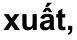

In [36]:
img_path = "/raid/kientdt/shared_drive_cv/ocr/kientdt/PaddleOCR/ocr_text_recog_hieunq_v2/Arial_Bold/train/img_169.jpg"
Image.open(img_path)

In [37]:
img = cv2.imread(img_path)
img = [img]
results = text_recognizer(img)
results

([('xuất,', 0.98775053)], 0.0070056915283203125)